In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import argparse
import time
import tensorflow as tf

from tuner import HyperparameterTuner

use_tpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver
    
%load_ext autoreload
%autoreload 2

In [2]:
hidden_layers = 2
hidden_units = 500
trials = 10
epochs = 10
task_home = ''
if use_tpu:
    task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = './'
checkpoint_path = task_home + 'fixed_softmax/checkpoints/'
summaries_path = task_home + 'fixed_softmax/summaries/'
data_path = task_home + 'MNIST_data/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'

In [3]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
else:
    sess = tf.Session()

In [4]:
tuner = HyperparameterTuner(sess=sess, hidden_layers=hidden_layers, hidden_units=hidden_units,
                            trials=trials, epochs=epochs,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            data_path=data_path, split_path=split_path)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting gs://continual_learning/permMNIST_EWC/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting gs://continual_learning/permMNIST_EWC/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting gs://continual_learning/permMNIST_EWC/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting gs://continual_learning/permMNIST_EWC/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.

In [5]:
from queue import PriorityQueue

In [6]:
# task 0
t = 0
queue = PriorityQueue()
for learning_rate in tuner.trial_learning_rates:
    tuner.train_on_task(t, learning_rate, queue)
tuner.best_parameters.append(queue.get())

training layers=2,hidden=500,lr=0.00094,multiplier=1067.63,mbsize=250,epochs=10,perm=0 with weights initialized at None
saving model layers=2,hidden=500,lr=0.00094,multiplier=1067.63,mbsize=250,epochs=10,perm=0 at time step 1759
finished training layers=2,hidden=500,lr=0.00094,multiplier=1067.63,mbsize=250,epochs=10,perm=0
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/fixed_softmax/checkpoints/layers=2,hidden=500,lr=0.00094,multiplier=1067.63,mbsize=250,epochs=10,perm=0.ckpt-1759
training layers=2,hidden=500,lr=0.00038,multiplier=2599.17,mbsize=250,epochs=10,perm=0 with weights initialized at None
saving model layers=2,hidden=500,lr=0.00038,multiplier=2599.17,mbsize=250,epochs=10,perm=0 at time step 1759
finished training layers=2,hidden=500,lr=0.00038,multiplier=2599.17,mbsize=250,epochs=10,perm=0
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/fixed_softmax/checkpoints/layers=2,hidden=500,lr=0.00038,multiplier=2599.17,

In [7]:
# accuracy on validation sets
t = 1
# tuner.best_parameters = []
# tuner.best_parameters.append((0.00077, 'layers=2,hidden=500,lr=0.00077,multiplier=1291.96,mbsize=250,epochs=10,perm=0'))
print("task0", tuner.classifier.test(sess=tuner.sess, model_name=tuner.best_parameters[t - 1][1], batch_xs=tuner.task_list[0].validation.images, batch_ys=tuner.task_list[0].validation.labels))
print("task1", tuner.classifier.test(sess=tuner.sess, model_name=tuner.best_parameters[t - 1][1], batch_xs=tuner.task_list[1].validation.images, batch_ys=tuner.task_list[1].validation.labels))

INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/fixed_softmax/checkpoints/layers=2,hidden=500,lr=0.00097,multiplier=1032.99,mbsize=250,epochs=10,perm=0.ckpt-1759
task0 0.98837495
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/fixed_softmax/checkpoints/layers=2,hidden=500,lr=0.00097,multiplier=1032.99,mbsize=250,epochs=10,perm=0.ckpt-1759
task1 0.0


In [8]:
# task1
t = 1
dataset_train = tuner.task_list[t].train
dataset_lagged = tuner.task_list[t - 1].train if t > 0 else None
model_init_name = tuner.best_parameters[t - 1][1] if t > 0 else None
MINI_BATCH_SIZE = 256
LOG_FREQUENCY = 100
dataset_train.initialize_iterator(MINI_BATCH_SIZE)
if (dataset_lagged is not None):
    dataset_lagged.initialize_iterator(MINI_BATCH_SIZE)

eval_frequency = 100
dropout_input = 1.0
result = {}

In [20]:
def train(t, fisher_multiplier, lr, model_name, model_init_name, only_softmax_train, num_updates=0):
    tuner.classifier.prepare_for_training(sess=tuner.sess, 
                                        model_name=model_name, 
                                        model_init_name=model_init_name, 
                                        fisher_multiplier=fisher_multiplier, 
                                        learning_rate=lr,
                                        only_softmax_train=only_softmax_train)
    val_acc = [[], []]
    val_loss = [[], []]
    loss = []
    loss_with_penalty = []
    cur_best_avg = 0.0
    cur_best_avg_num_updates = -1
    i = 0
    count_not_improving = 0
    while (True):
        cur_loss, cur_loss_with_penalty = tuner.classifier.minibatch_sgd(tuner.sess, i, dataset_train, MINI_BATCH_SIZE, LOG_FREQUENCY,
                                                                        tuner.softmax_weight_mask_values[t], 
                                                                        tuner.softmax_bias_mask_values[t])
        loss.append(cur_loss)
        loss_with_penalty.append(cur_loss_with_penalty)
        if (i % eval_frequency == 0):
            cur_iter_avg = 0.0
            cur_iter_num_classes = 0 # actually doesn't depend on iterations
            for j in range(t + 1):
                val_data = tuner.task_list[j].validation
                feed_dict = tuner.classifier.create_feed_dict(val_data.images, val_data.labels, keep_input=1.0, keep_hidden=1.0)
                accuracy = sess.run([tuner.classifier.loss, tuner.classifier.accuracy], feed_dict=feed_dict)
                val_loss[j].append(accuracy[0])
                val_acc[j].append(accuracy[1])
                cur_iter_avg += accuracy[1] * len(tuner.split[j]) # assuming all classes are equally likely
                cur_iter_num_classes += len(tuner.split[j])
            cur_iter_avg /= cur_iter_num_classes

            if (val_acc[0][-1] < val_acc[1][-1]):
                if (cur_best_avg >= cur_iter_avg):
                    count_not_improving += 1
                else:
                    count_not_improving = 0

            if (cur_iter_avg > cur_best_avg):
                cur_best_avg = cur_iter_avg
                cur_best_avg_num_updates = i

            if (count_not_improving >= 5):
                if (num_updates == 0):
                    break
        if ((num_updates != 0) and (i > num_updates)):
            break
        i += 1
        
    return val_acc, val_loss, loss, loss_with_penalty, cur_best_avg, cur_best_avg_num_updates

In [16]:
only_softmax_train = True
num_updates = 5000
dropouts = [1.0]
# fisher_multipliers = np.logspace(4, 7, 30)
fisher_multipliers = [0.0]
learning_rates = [5e-6]
best_avg = 0.0
best_params = -1
best_num_updates = -1
for dropout in dropouts:
    for fisher_multiplier in fisher_multipliers:
        for lr in learning_rates:
            print("dropout: %f, fisher_multiplier: %e, lr: %e" % (dropout, fisher_multiplier, lr))
            start_time = time.time()
            model_name = tuner.file_name(lr, t)
            tuner.classifier.set_dropout(dropout_input, dropout)
            val_acc, val_loss, loss, loss_with_penalty, cur_best_avg, cur_best_avg_num_updates = train(t, fisher_multiplier, lr, model_name, model_init_name, only_softmax_train)
        cur_params = (dropout, fisher_multiplier, lr)
        result[cur_params] = {}
        result[cur_params]["val_acc"] = val_acc
        result[cur_params]["val_loss"] = val_loss
        result[cur_params]["loss"] = loss
        result[cur_params]["loss_with_penalty"] = loss_with_penalty
        result[cur_params]["best_avg"] = (cur_best_avg, cur_best_avg_num_updates)
        if (best_avg < cur_best_avg):
            best_avg = cur_best_avg
            best_params = cur_params
            best_num_updates = cur_best_avg_num_updates
        print("time taken: %f" % (time.time() - start_time))
        print("loss with penalty: %f, loss: %f, val0 accuracy: %f, val1 accuracy: %f"
              % (loss_with_penalty[-1], loss[-1], 
                 val_acc[0][cur_best_avg_num_updates // eval_frequency], val_acc[1][cur_best_avg_num_updates // eval_frequency]))

dropout: 1.000000, fisher_multiplier: 0.000000e+00, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/fixed_softmax/checkpoints/layers=2,hidden=500,lr=0.00097,multiplier=1032.99,mbsize=250,epochs=10,perm=0.ckpt-1759
time taken: 181.053452
loss with penalty: 0.157604, loss: 0.157604, val0 accuracy: 0.960178, val1 accuracy: 0.805195


best_avg: 9.429577e-01, best_params: (1.0, 0.0, 5e-06)
best_params: dropout: 1.000000, fisher_multiplier: 0.000000e+00, lr: 5.000000e-06
dropout: 1.000000, fisher_multiplier: 0.000000e+00, lr: 5.000000e-06
cur_best_avg: 9.429577e-01, num_updates: 14100
val0_acc: 0.960178, val1_acc: 0.805195
final val0_acc: 0.909226, val1_acc: 0.937229


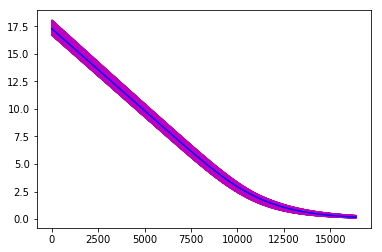

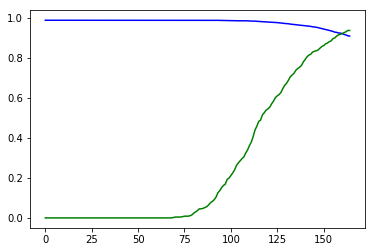

In [17]:
print("best_avg: %e, best_params: %s" % (best_avg, str(best_params)))
print("best_params: dropout: %f, fisher_multiplier: %e, lr: %e" % best_params)

for k, v in result.items():
    cur_res = v
    x = np.arange(0, len(cur_res['loss']), eval_frequency)
    cur_best_avg = cur_res['best_avg']
    print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
    print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg[0], cur_best_avg[1]))
    print("val0_acc: %f, val1_acc: %f" %
        (cur_res['val_acc'][0][cur_best_avg[1] // eval_frequency], cur_res['val_acc'][1][cur_best_avg[1] // eval_frequency]))
    print("final val0_acc: %f, val1_acc: %f" % (cur_res['val_acc'][0][-1], cur_res['val_acc'][1][-1]))
    plt.plot(cur_res['loss_with_penalty'], color='g')
    plt.plot(cur_res['loss'], color='m')
    plt.plot(x, cur_res['val_loss'][1], color='b')
    plt.show()
    plt.plot(cur_res['val_acc'][0], color='b')
    plt.plot(cur_res['val_acc'][1], color='g')
    plt.show()

In [18]:
def get_confusion_matrix(tuner):
    num_labels = 10
    pred = np.array([])
    actual = np.array([])
    for j in range(t + 1):
        val_data = tuner.task_list[j].validation
        feed_dict = tuner.classifier.create_feed_dict(val_data.images, val_data.labels, keep_input=1.0, keep_hidden=1.0)
        cur_scores, cur_y = tuner.classifier.get_predictions(sess, feed_dict)
        cur_pred = np.argmax(cur_scores, 1)
        cur_actual = np.argmax(cur_y, 1)
        actual = np.concatenate([actual, cur_actual])
        pred = np.concatenate([pred, cur_pred])
    confusion_matrix = np.zeros((num_labels,num_labels), dtype=np.int64)

    for i in range(actual.shape[0]):
        confusion_matrix[int(actual[i]), int(pred[i])] += 1
    return confusion_matrix

def print_confusion_matrix(confusion_matrix):
    print("%3d" % (0, ), end=' ')
    for j in range(confusion_matrix.shape[1]):
        print("%3d" % (j, ), end=' ')
    print("")
    for i in range(confusion_matrix.shape[0]):
        print("%3d" % (i, ), end=' ')
        for j in range(confusion_matrix.shape[1]):
            print("%3d" % (confusion_matrix[i][j], ), end= ' ')
        print("")

In [19]:
# confusion matrix before training
# train on best hyperparameters

# best_params = (1.0, 10 ** (18 / 19 + 4), 5e-6)
# best_num_updates = 3600

dropout, fisher_multiplier, lr = best_params
best_num_updates = result[best_params]['best_avg'][1]

model_name = tuner.file_name(lr, t)
tuner.classifier.prepare_for_training(sess=tuner.sess, 
                                    model_name=model_name, 
                                    model_init_name=model_init_name, 
                                    fisher_multiplier=fisher_multiplier, 
                                    learning_rate=lr,
                                    only_softmax_train=only_softmax_train)

confusion_matrix = get_confusion_matrix(tuner)
print_confusion_matrix(confusion_matrix)


INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/fixed_softmax/checkpoints/layers=2,hidden=500,lr=0.00097,multiplier=1032.99,mbsize=250,epochs=10,perm=0.ckpt-1759
  0   0   1   2   3   4   5   6   7   8   9 
  0 477   0   0   1   0   0   1   0   0   0 
  1   0 558   0   1   1   0   0   3   0   0 
  2   0   1 486   0   0   0   0   1   0   0 
  3   0   0   3 479   1   5   1   4   0   0 
  4   0   0   1   0 531   1   0   2   0   0 
  5   0   1   1   4   1 425   2   0   0   0 
  6   1   1   1   0   1   1 496   0   0   0 
  7   1   0   2   0   2   1   0 544   0   0 
  8   5  27 158 137  26  85  16   8   0   0 
  9   0   0   0   0   0   0   0   0   0   0 


In [21]:
# train on best hyperparameters
dropout, fisher_multiplier, lr = best_params
print("dropout: %f, fisher_multiplier: %e, lr: %e" % (dropout, fisher_multiplier, lr))
start_time = time.time()
model_name = tuner.file_name(lr, t)
tuner.classifier.set_dropout(dropout_input, dropout)
val_acc, val_loss, loss, loss_with_penalty, cur_best_avg, cur_best_avg_num_updates = train(t, fisher_multiplier, lr, model_name, model_init_name, only_softmax_train, best_num_updates)
# cur_params = (dropout, fisher_multiplier, lr)
# result[cur_params] = {}
# result[cur_params]["val_acc"] = val_acc
# result[cur_params]["val_loss"] = val_loss
# result[cur_params]["loss"] = loss
# result[cur_params]["loss_with_penalty"] = loss_with_penalty
# result[cur_params]["best_avg"] = (cur_best_avg, cur_best_avg_num_updates)
print("time taken: %f" % (time.time() - start_time))
print("loss with penalty: %f, loss: %f, val0 accuracy: %f, val1 accuracy: %f"
      % (loss_with_penalty[-1], loss[-1], 
         val_acc[0][cur_best_avg_num_updates // eval_frequency], val_acc[1][cur_best_avg_num_updates // eval_frequency]))

dropout: 1.000000, fisher_multiplier: 0.000000e+00, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/fixed_softmax/checkpoints/layers=2,hidden=500,lr=0.00097,multiplier=1032.99,mbsize=250,epochs=10,perm=0.ckpt-1759
time taken: 157.005314
loss with penalty: 0.493784, loss: 0.493784, val0 accuracy: 0.960178, val1 accuracy: 0.805195


In [22]:
# confusion matrix 
# finding which digits are being confused by classifier
confusion_matrix = get_confusion_matrix(tuner)
print_confusion_matrix(confusion_matrix)

  0   0   1   2   3   4   5   6   7   8   9 
  0 458   0   0   1   0   0   1   0  19   0 
  1   0 532   0   0   0   0   0   1  30   0 
  2   0   0 463   0   0   0   0   1  24   0 
  3   0   0   2 464   0   3   0   3  21   0 
  4   0   0   0   0 526   1   0   2   6   0 
  5   0   0   0   1   0 417   1   0  15   0 
  6   1   0   0   0   1   0 486   0  13   0 
  7   0   0   1   0   0   1   0 536  12   0 
  8   1   5  19  30   4  28   3   0 372   0 
  9   0   0   0   0   0   0   0   0   0   0 


In [23]:
# train on best hyperparameters
dropout, fisher_multiplier, lr = best_params
print("dropout: %f, fisher_multiplier: %e, lr: %e" % (dropout, fisher_multiplier, lr))
start_time = time.time()
model_name = tuner.file_name(lr, t)
tuner.classifier.set_dropout(dropout_input, dropout)
val_acc, val_loss, loss, loss_with_penalty, cur_best_avg, cur_best_avg_num_updates = train(t, fisher_multiplier, lr, model_name, model_init_name, only_softmax_train, 20000)
# cur_params = (dropout, fisher_multiplier, lr)
# result[cur_params] = {}
# result[cur_params]["val_acc"] = val_acc
# result[cur_params]["val_loss"] = val_loss
# result[cur_params]["loss"] = loss
# result[cur_params]["loss_with_penalty"] = loss_with_penalty
# result[cur_params]["best_avg"] = (cur_best_avg, cur_best_avg_num_updates)
print("time taken: %f" % (time.time() - start_time))
print("loss with penalty: %f, loss: %f, val0 accuracy: %f, val1 accuracy: %f"
      % (loss_with_penalty[-1], loss[-1], 
         val_acc[0][cur_best_avg_num_updates // eval_frequency], val_acc[1][cur_best_avg_num_updates // eval_frequency]))

# confusion matrix 
# finding which digits are being confused by classifier
confusion_matrix = get_confusion_matrix(tuner)
print_confusion_matrix(confusion_matrix)

dropout: 1.000000, fisher_multiplier: 0.000000e+00, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/fixed_softmax/checkpoints/layers=2,hidden=500,lr=0.00097,multiplier=1032.99,mbsize=250,epochs=10,perm=0.ckpt-1759
time taken: 221.683051
loss with penalty: 0.110508, loss: 0.110508, val0 accuracy: 0.960178, val1 accuracy: 0.805195
  0   0   1   2   3   4   5   6   7   8   9 
  0 327   0   0   0   0   0   0   0 152   0 
  1   0 320   0   0   0   0   0   0 243   0 
  2   0   0 331   0   0   0   0   1 156   0 
  3   0   0   0 371   0   0   0   0 122   0 
  4   0   0   0   0 469   0   0   0  66   0 
  5   0   0   0   0   0 325   0   0 109   0 
  6   0   0   0   0   0   0 424   0  77   0 
  7   0   0   0   0   0   0   0 437 113   0 
  8   0   0   1   2   0   3   0   0 456   0 
  9   0   0   0   0   0   0   0   0   0   0 


In [24]:
# test accuracy
for j in range(t + 1):
    test_data = tuner.task_list[j].test
    feed_dict = tuner.classifier.create_feed_dict(test_data.images, test_data.labels, keep_input=1.0, keep_hidden=1.0)
    accuracy = sess.run([tuner.classifier.loss, tuner.classifier.accuracy], feed_dict=feed_dict)
    print(accuracy)

[0.8161023, 0.7323188]
[0.05061009, 0.98767966]


In [25]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()